<a href="https://colab.research.google.com/github/Vivek-Mallavarapu/Glucoma/blob/main/squeeze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
# from keras.layers import Activation
# from keras.layers.core import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization
# from keras.layers.normalization import BatchNormalization
# from keras.layers.convolutional import *
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
from keras.callbacks import History
history = History()

In [ ]:
!7z x DataPro.zip


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 23966343 bytes (23 MiB)

Extracting archive: DataPro.zip
--
Path = DataPro.zip
Type = zip
Physical Size = 23966343

  0%     58% 366 - DataPro/train/Glaucoma/Im645_g_ACRIMA.jpg                                                    Everything is Ok

Folders: 7
Files: 704
Size:       25602079
Compressed: 23966343


In [ ]:
# # Setting up local path
# train_path = "C:/Users/KRISHNA SANTOSH/Documents/anaconda_projects/Colour_Glaucoma_Classifier/Analyze_Glaucoma/content/datasets/DataPro/train"
# test_path = "C:/Users/KRISHNA SANTOSH/Documents/anaconda_projects/Colour_Glaucoma_Classifier/Analyze_Glaucoma/content/datasets/DataPro/test"
# valid_path = "C:/Users/KRISHNA SANTOSH/Documents/anaconda_projects/Colour_Glaucoma_Classifier/Analyze_Glaucoma/content/datasets/DataPro/validate"

train_path = "/content/DataPro/train"
test_path = "/content/DataPro/test"
valid_path = "/content/DataPro/validate"

In [ ]:
train_batches = ImageDataGenerator(rotation_range=10, width_shift_range=0.1,
       height_shift_range=0.1, shear_range=0.15, zoom_range=0.1,
       channel_shift_range=10., horizontal_flip=True).flow_from_directory(train_path, target_size=(224,224), classes =['Normal','Glaucoma'], batch_size=32)
test_batches = ImageDataGenerator(rotation_range=10, width_shift_range=0.1,
       height_shift_range=0.1, shear_range=0.15, zoom_range=0.1,
       channel_shift_range=10., horizontal_flip=True).flow_from_directory(test_path, target_size=(224,224), classes =['Normal','Glaucoma'], batch_size=32)

Found 604 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                         title = 'Confusion Matrix',
                         cmap=plt.cm.Blues):

  plt.imshow(cm, interpolation = 'nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation = 45)
  plt.yticks(tick_marks, classes)

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1) [:, np.newaxis]
    print("Normalized Confusion Matrix")
  else:
    print("Confusion Matrix without normalization")

  print(cm)

  thresh = cm.max() / 2.

  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j,i, cm[i,j],
            horizontalalignment ="center",
            color = "white" if cm[i,j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [ ]:
def create_attention_55(x):
    # Attention mechanism
    attention_weights = tf.keras.layers.Dense(units=1, activation="sigmoid")(x)
    attention_weights = tf.keras.layers.Reshape((-1,))(attention_weights)
    attention_weights = tf.keras.layers.Softmax(axis=1)(attention_weights)
    attention_weights = keras.layers.Reshape((55, 55))(attention_weights)
    attention_output = tf.keras.layers.Dot(axes=[1,1])([attention_weights, x])
    return attention_output

In [ ]:
def create_attention_27(x):
    # Attention mechanism
    attention_weights = tf.keras.layers.Dense(units=1, activation="sigmoid")(x)
    attention_weights = tf.keras.layers.Reshape((-1,))(attention_weights)
    attention_weights = tf.keras.layers.Softmax(axis=1)(attention_weights)
    attention_weights = keras.layers.Reshape((27, 27))(attention_weights)
    attention_output = tf.keras.layers.Dot(axes=[1,1])([attention_weights, x])
    return attention_output

In [ ]:
def create_attention_13(x):
    # Attention mechanism
    attention_weights = tf.keras.layers.Dense(units=1, activation="sigmoid")(x)
    attention_weights = tf.keras.layers.Reshape((-1,))(attention_weights)
    attention_weights = tf.keras.layers.Softmax(axis=1)(attention_weights)
    attention_weights = keras.layers.Reshape((13, 13))(attention_weights)
    attention_output = tf.keras.layers.Dot(axes=[1,1])([attention_weights, x])
    return attention_output

In [ ]:

def create_fire_module(x, nb_squeeze_filter, name, use_bypass=False):
    nb_expand_filter = 4 * nb_squeeze_filter
    squeeze    = Conv2D(nb_squeeze_filter,(1,1), activation='relu', padding='same', name='%s_squeeze'%name)(x)
    expand_1x1 = Conv2D(nb_expand_filter, (1,1), activation='relu', padding='same', name='%s_expand_1x1'%name)(squeeze)
    expand_3x3 = Conv2D(nb_expand_filter, (3,3), activation='relu', padding='same', name='%s_expand_3x3'%name)(squeeze)
    axis = get_axis()
    x_ret = Concatenate(axis=axis, name='%s_concatenate'%name)([expand_1x1, expand_3x3])
    if use_bypass:
        x_ret = Add(name='%s_concatenate_bypass'%name)([x_ret, x])
    return x_ret

def output(x, nb_classes):
    x = Conv2D(nb_classes, (1,1), strides=(1,1), padding='valid', name='conv10')(x)
    x = GlobalAveragePooling2D(name='avgpool10')(x)
    x = Activation("softmax")(x)
    return x

def get_axis():
    axis = -1 if K.image_data_format() == 'channels_last' else 1
    return axis

input_shape = (224,224,3)
nb_classes = 2
dropout_rate = None
compression = 1.0

input_img = Input(shape=input_shape)
x = Conv2D(int(64*compression), (3,3), activation='relu', strides=(2,2), padding='same', name='conv1')(input_img)
x = MaxPooling2D(pool_size=(3,3), strides=(2,2), name='maxpool1')(x)
x = create_fire_module(x, int(16*compression), name='fire2')
print(x.shape)
x=create_attention_55(x)
x = create_fire_module(x, int(16*compression), name='fire3')
x = MaxPooling2D(pool_size=(3,3), strides=(2,2), name='maxpool3')(x)
x = create_fire_module(x, int(32*compression), name='fire4')
print(x.shape)
x=create_attention_27(x)
x = create_fire_module(x, int(32*compression), name='fire5')
x = MaxPooling2D(pool_size=(3,3), strides=(2,2), name='maxpool5')(x)
x = create_fire_module(x, int(48*compression), name='fire6')
x = create_fire_module(x, int(48*compression), name='fire7')
print(x.shape)
x=create_attention_13(x)
x = create_fire_module(x, int(64*compression), name='fire8')
x = create_fire_module(x, int(64*compression), name='fire9')
if dropout_rate:
    x = Dropout(dropout_rate)(x)
x = output(x, nb_classes)
model = Model(inputs=input_img, outputs=x)
model.summary()

(None, 55, 55, 128)
(None, 27, 27, 256)
(None, 13, 13, 384)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 112, 112, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 maxpool1 (MaxPooling2D)     (None, 55, 55, 64)           0         ['conv1[0][0]']               
                                                                                                  
 fire2_squeeze (Conv2D)      (None, 55, 55, 16)           1040      ['maxpool1[0][0]']            
                                  

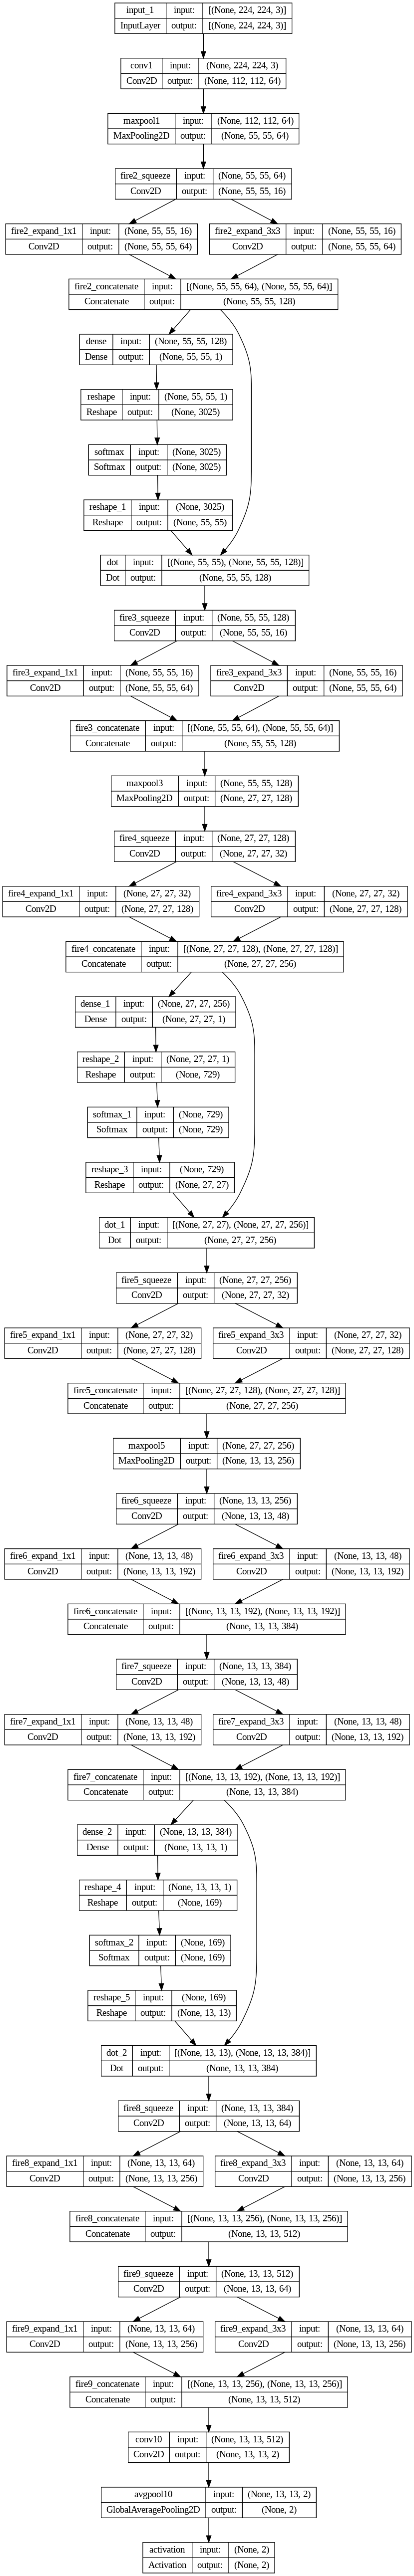

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(Adam(learning_rate=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the Model
history = model.fit(train_batches,
          epochs=30,
          validation_data=test_batches,
          callbacks=[
          # Stopping our training if val_accuracy doesn't improve after 20 epochs
          tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                           patience=20),
          # Saving the best weights of our model in the model directory

          # We don't want to save just the weight, but also the model architecture
          tf.keras.callbacks.ModelCheckpoint('/content/DataPro/Trained_Models/model_{val_accuracy:.3f}.h5',
                                           save_best_only=True,
                                           save_weights_only=False,
                                           monitor='val_accuracy'
                                             )
    ])

Epoch 1/30
19/19 [==============================] - 10s 526ms/step - loss: 0.4167 - accuracy: 0.8030 - val_loss: 0.4110 - val_accuracy: 0.8000
Epoch 2/30
19/19 [==============================] - 11s 570ms/step - loss: 0.4012 - accuracy: 0.8063 - val_loss: 0.3220 - val_accuracy: 0.8400
Epoch 3/30
19/19 [==============================] - 10s 549ms/step - loss: 0.4040 - accuracy: 0.7930 - val_loss: 0.4997 - val_accuracy: 0.7000
Epoch 4/30
19/19 [==============================] - 9s 453ms/step - loss: 0.4066 - accuracy: 0.7947 - val_loss: 0.4146 - val_accuracy: 0.7800
Epoch 5/30
19/19 [==============================] - 11s 563ms/step - loss: 0.4136 - accuracy: 0.7947 - val_loss: 0.4294 - val_accuracy: 0.7300
Epoch 6/30
19/19 [==============================] - 10s 541ms/step - loss: 0.3953 - accuracy: 0.7997 - val_loss: 0.4088 - val_accuracy: 0.7800
Epoch 7/30
19/19 [==============================] - 9s 458ms/step - loss: 0.4001 - accuracy: 0.7666 - val_loss: 0.3765 - val_accuracy: 0.8200
E

In [ ]:
tf.keras.models.save_model(model,'model_0.970.h5')


<ipython-input-15-52dd254c39ca>:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model,'model_0.970.h5')


In [ ]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 67.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 13.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.6/314.6 kB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 102.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 11.5 M

In [ ]:


import gradio as gr
import tensorflow as tf
import numpy as np
from PIL import Image
model = tf.keras.models.load_model('/content/DataPro/Trained_Models/model_0.960.h5')

# Define function to make predictions
def classify_image(image):
    image = Image.fromarray(image.astype('uint8'), 'RGB')  # Convert numpy array to PIL Image
    image = image.resize((224, 224))  # Resize image to match model input size
    image = np.array(image) / 255.0  # Normalize pixel values
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    prediction = model.predict(image)  # Make prediction
    class_names = ['Glaucoma', 'Normal']
    return {class_names[i]: float(prediction[0][i]) for i in range(len(class_names))}

# Create Gradio interface
img = gr.inputs.Image(shape=(224, 224))
op = gr.outputs.Label(num_top_classes=2)

interface = gr.Interface(fn=classify_image, inputs=img, outputs=op, title='Glaucoma Classification')
interface.launch()

AttributeError: module 'gradio' has no attribute 'inputs'

In [ ]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.2 MB/s eta 0:00:00


In [ ]:

%%writefile app.py
import streamlit as st
import tensorflow as tf
import streamlit as st


@st.cache(allow_output_mutation=True)
def load_model():
  model=tf.keras.models.load_model('/content/DataPro/Trained_Models/model_0.970.h5')
  return model
with st.spinner('Model is being loaded..'):
  model=load_model()

st.write("""
         # Flower Classification
         """
         )

file = st.file_uploader("Please upload an brain scan file", type=["jpg", "png"])
import cv2
from PIL import Image, ImageOps
import numpy as np
st.set_option('deprecation.showfileUploaderEncoding', False)
def import_and_predict(image_data, model):

        size = (180,180)
        image = ImageOps.fit(image_data, size, Image.ANTIALIAS)
        image = np.asarray(image)
        img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #img_resize = (cv2.resize(img, dsize=(75, 75),    interpolation=cv2.INTER_CUBIC))/255.

        img_reshape = img[np.newaxis,...]

        prediction = model.predict(img_reshape)

        return prediction
if file is None:
    st.text("Please upload an image file")
else:
    image = Image.open(file)
    st.image(image, use_column_width=True)
    predictions = import_and_predict(image, model)
    score = tf.nn.softmax(predictions[0])
    class_names=['Glucoma','Normal']
    string="This image most likely is: "+class_names [np.argmax (predictions)]
    st.success(string)
    st.write(predictions)
    st.write(score)
    print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


Overwriting app.py


In [ ]:
!pip install pyngrok

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
!ngrok config add-authtoken 2gB2WSrenwnm5VwoxsH8iTQmari_7URXfJnM2dWwyv7Ba5vDd

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
!nohup streamlit run app.py &

In [ ]:
def plots(ims, figsize=(12,6), rows=5, interp=False, titles=None):
  if type(ims[0]) is np.ndarray:
    ims = np.array(ims).astype(np.uint8)
    if(ims.shape[-1] != 3):
      ims = ims.transpose ((0,2,3,1))
  f = plt.figure(figsize = figsize)
  cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows +1
  for i in range(len(ims)):
    sp = f.add_subplot (rows, cols, i+1)
    sp.axis('Off')
    if titles is not None:
      sp.set_title(titles[i], fontsize =10)
    plt.imshow(ims[i], interpolation=None if interp else 'none')

In [ ]:
test_batches_fine = ImageDataGenerator(rotation_range=10, width_shift_range=0.1,
       height_shift_range=0.1, shear_range=0.15, zoom_range=0.1,
       channel_shift_range=10., horizontal_flip=True).flow_from_directory(test_path, target_size=(224,224), classes =['Normal','Glaucoma'], batch_size=50)

Found 100 images belonging to 2 classes.


In [ ]:
test_imgs, test_labels = next(test_batches_fine)

In [ ]:
x_labels = test_labels.argmax(axis=1)
print(x_labels)

[1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 0 1 1 1 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 1]


In [ ]:

predictions = model.predict(test_batches_fine, steps=1, verbose=0)

# loading the best perfoming model
loaded_model = tf.keras.models.load_model('/content/DataPro/Trained_Models/model_0.970.h5')

#print('Caling test batches:', test_batches_fine)

predictions = loaded_model.predict(test_batches_fine, steps=1, verbose=0)
print(predictions)

# Getting test accuracy and loss
test_loss, test_acc = loaded_model.evaluate(test_batches_fine)
print('Test loss: {} Test Acc: {}'.format(test_loss, test_acc))

[[0.49575526 0.50424474]
 [0.290293   0.70970696]
 [0.19490416 0.8050959 ]
 [0.83399516 0.16600478]
 [0.01235851 0.98764145]
 [0.36711326 0.6328867 ]
 [0.35074744 0.64925253]
 [0.8517802  0.14821985]
 [0.77811015 0.22188982]
 [0.25264004 0.74735993]
 [0.3837537  0.61624634]
 [0.01912652 0.9808735 ]
 [0.37077737 0.6292227 ]
 [0.68151003 0.31849   ]
 [0.46150208 0.5384979 ]
 [0.1543844  0.84561557]
 [0.8128646  0.18713543]
 [0.18475701 0.81524307]
 [0.50325596 0.49674398]
 [0.69981265 0.30018735]
 [0.54958755 0.45041245]
 [0.01022044 0.98977953]
 [0.25703046 0.7429696 ]
 [0.2048188  0.79518116]
 [0.62032765 0.3796723 ]
 [0.34777507 0.65222496]
 [0.29942074 0.7005792 ]
 [0.06914993 0.9308501 ]
 [0.5629238  0.4370762 ]
 [0.01283409 0.98716587]
 [0.00412672 0.9958733 ]
 [0.4872886  0.5127114 ]
 [0.23538783 0.76461214]
 [0.0356011  0.9643989 ]
 [0.2976611  0.7023389 ]
 [0.3661848  0.63381517]
 [0.06269857 0.93730146]
 [0.32071942 0.6792806 ]
 [0.41145846 0.58854157]
 [0.69640565 0.30359435]


In [ ]:
y_labels = predictions.argmax(axis=1)
print(y_labels)

[1 1 1 0 1 1 1 0 0 1 1 1 1 0 1 1 0 1 0 0 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 0 1 0 1 1 1]


In [ ]:
from sklearn.metrics import classification_report
cm = confusion_matrix(x_labels, y_labels)
tp, fn, fp, tn = confusion_matrix(x_labels,y_labels,labels=[1,0]).reshape(-1)
print('Outcome values :tp, fn, fp, tn: \n', tp, fn, fp, tn)
# classification report for precision, recall f1-score and accuracy
matrix = classification_report(x_labels,y_labels,labels=[1,0])
print('Classification report : \n',matrix)

Outcome values :tp, fn, fp, tn: 
 31 12 6 1
Classification report : 
               precision    recall  f1-score   support

           1       0.84      0.72      0.77        43
           0       0.08      0.14      0.10         7

    accuracy                           0.64        50
   macro avg       0.46      0.43      0.44        50
weighted avg       0.73      0.64      0.68        50



In [ ]:
cm_plot_labels = ['Normal','Glaucoma']

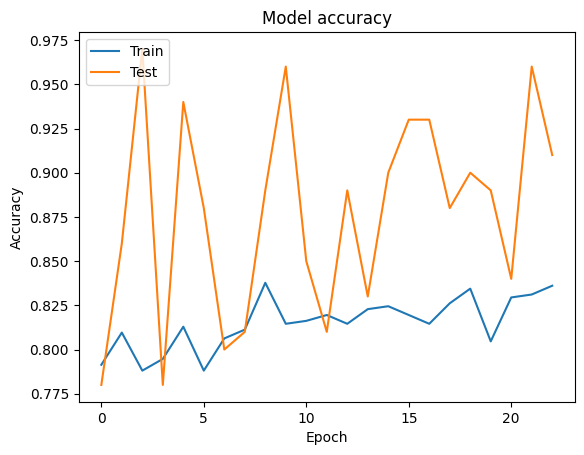

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

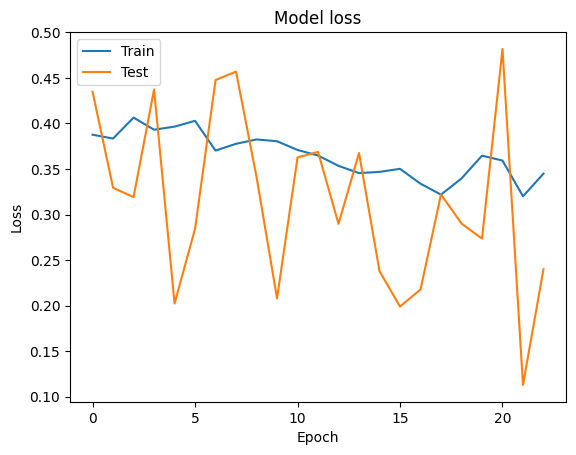

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Confusion Matrix without normalization
[[ 1  6]
 [12 31]]


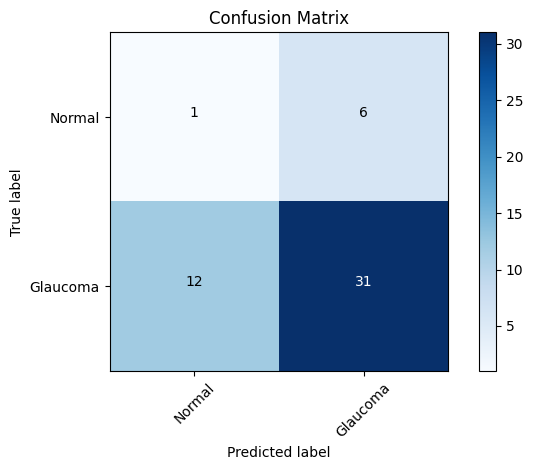

In [ ]:
plot_confusion_matrix(cm, cm_plot_labels, title ='Confusion Matrix')